## Linear Quantile Regression Notebook
Author: George Panagiotou
CID: 02527334

# Forecasting track

In [1]:
import pandas as pd
import numpy as np
from comp_utils import *
import os
import os
import joblib
from sklearn.linear_model import QuantileRegressor
from sklearn.metrics import mean_pinball_loss
from concurrent.futures import ThreadPoolExecutor, as_completed

## Test and train data:

In [2]:
Wind_train1 = pd.read_csv('data/LightGB/Wind_quantiles_train_set.csv')
Wind_train1 = Wind_train1.rename(columns={'q10': '1_qw10','q20': '1_qw20','q30': '1_qw30','q40': '1_qw40','q50': '1_qw50','q60': '1_qw60','q70': '1_qw70','q80': '1_qw80','q90': '1_qw90' }) 
Solar_train1 = pd.read_csv('data/LightGB/Solar_quantiles_train_set.csv')
Solar_train1 = Solar_train1.rename(columns={'q10': '1_qs10','q20': '1_qs20','q30': '1_qs30','q40': '1_qs40','q50': '1_qs50','q60': '1_qs60','q70': '1_qs70','q80': '1_qs80','q90': '1_qs90' }) 

Train_set = Solar_train1.merge(Wind_train1, on='time')

Wind_train2 = pd.read_csv('data/ExtremeGB/Wind_quantiles_train_set.csv')
Wind_train2 = Wind_train2.rename(columns={'q10': '2_qw10','q20': '2_qw20','q30': '2_qw30','q40': '2_qw40','q50': '2_qw50','q60': '2_qw60','q70': '2_qw70','q80': '2_qw80','q90': '2_qw90' })
Wind_train2 = Wind_train2.drop(columns=['Wind_MWh_credit'])

Solar_train2 = pd.read_csv('data/ExtremeGB/Solar_quantiles_train_set.csv')
Solar_train2 = Solar_train2.rename(columns={'q10': '2_qs10','q20': '2_qs20','q30': '2_qs30','q40': '2_qs40','q50': '2_qs50','q60': '2_qs60','q70': '2_qs70','q80': '2_qs80','q90': '2_qs90' }) 
Solar_train2 = Solar_train2.drop(columns=['Solar_MWh_credit'])


Wind_train3 = pd.read_csv('data/LinearQ/Wind_train_quantiles.csv')
Wind_train3 = Wind_train3.rename(columns={'q10': '3_qw10','q20': '3_qw20','q30': '3_qw30','q40': '3_qw40','q50': '3_qw50','q60': '3_qw60','q70': '3_qw70','q80': '3_qw80','q90': '3_qw90' })
Wind_train3 = Wind_train3.drop(columns=['Wind_MWh_credit'])

Solar_train3 = pd.read_csv('data/LinearQ/Solar_train_quantiles.csv')
Solar_train3 = Solar_train3.rename(columns={'q10': '3_qs10','q20': '3_qs20','q30': '3_qs30','q40': '3_qs40','q50': '3_qs50','q60': '3_qs60','q70': '3_qs70','q80': '3_qs80','q90': '3_qs90' }) 
Solar_train3 = Solar_train3.drop(columns=['Solar_MWh_credit'])

Train_set = Train_set.merge(Wind_train2, on='time')
Train_set = Train_set.merge(Solar_train2, on='time')
Train_set = Train_set.merge(Wind_train3, on='time')
Train_set = Train_set.merge(Solar_train3, on='time')
train_target_variable = Train_set['Wind_MWh_credit'] + Train_set['Solar_MWh_credit']

Train_set = Train_set.rename(columns={'time':'valid_time'})
Train_set['valid_time'] = pd.to_datetime(Train_set['valid_time'])
train_times = Train_set['valid_time']
Train_set = add_cyclic_features(Train_set)
Train_set = Train_set.drop(columns=['Wind_MWh_credit','Solar_MWh_credit','valid_time'])
print('Train features after removing columns:', Train_set.shape)

Train features after removing columns: (56284, 63)


In [3]:
# Read and rename test datasets
Wind_test1 = pd.read_csv('data/LightGB/Wind_quantiles_test_set.csv')
Wind_test1 = Wind_test1.rename(columns={'q10': '1_qw10', 'q20': '1_qw20', 'q30': '1_qw30', 'q40': '1_qw40', 'q50': '1_qw50', 'q60': '1_qw60', 'q70': '1_qw70', 'q80': '1_qw80', 'q90': '1_qw90'})
Solar_test1 = pd.read_csv('data/LightGB/Solar_quantiles_test_set.csv')
Solar_test1 = Solar_test1.rename(columns={'q10': '1_qs10', 'q20': '1_qs20', 'q30': '1_qs30', 'q40': '1_qs40', 'q50': '1_qs50', 'q60': '1_qs60', 'q70': '1_qs70', 'q80': '1_qs80', 'q90': '1_qs90'})

Test_set = Solar_test1.merge(Wind_test1, on='time')

Wind_test2 = pd.read_csv('data/ExtremeGB/Wind_quantiles_test_set.csv')
Wind_test2 = Wind_test2.rename(columns={'q10': '2_qw10', 'q20': '2_qw20', 'q30': '2_qw30', 'q40': '2_qw40', 'q50': '2_qw50', 'q60': '2_qw60', 'q70': '2_qw70', 'q80': '2_qw80', 'q90': '2_qw90'})
Wind_test2 = Wind_test2.drop(columns=['Wind_MWh_credit'])

Solar_test2 = pd.read_csv('data/ExtremeGB/Solar_quantiles_test_set.csv')
Solar_test2 = Solar_test2.rename(columns={'q10': '2_qs10', 'q20': '2_qs20', 'q30': '2_qs30', 'q40': '2_qs40', 'q50': '2_qs50', 'q60': '2_qs60', 'q70': '2_qs70', 'q80': '2_qs80', 'q90': '2_qs90'})
Solar_test2 = Solar_test2.drop(columns=['Solar_MWh_credit'])

Wind_test3 = pd.read_csv('data/LinearQ/Wind_test_quantiles.csv')
Wind_test3 = Wind_test3.rename(columns={'q10': '3_qw10', 'q20': '3_qw20', 'q30': '3_qw30', 'q40': '3_qw40', 'q50': '3_qw50', 'q60': '3_qw60', 'q70': '3_qw70', 'q80': '3_qw80', 'q90': '3_qw90'})
Wind_test3 = Wind_test3.drop(columns=['Wind_MWh_credit'])

Solar_test3 = pd.read_csv('data/LinearQ/Solar_test_quantiles.csv')
Solar_test3 = Solar_test3.rename(columns={'q10': '3_qs10', 'q20': '3_qs20', 'q30': '3_qs30', 'q40': '3_qs40', 'q50': '3_qs50', 'q60': '3_qs60', 'q70': '3_qs70', 'q80': '3_qs80', 'q90': '3_qs90'})
Solar_test3 = Solar_test3.drop(columns=['Solar_MWh_credit'])

Test_set = Test_set.merge(Wind_test2, on='time')
Test_set = Test_set.merge(Solar_test2, on='time')
Test_set = Test_set.merge(Wind_test3, on='time')
Test_set = Test_set.merge(Solar_test3, on='time')
test_target_variable = Test_set['Wind_MWh_credit'] + Test_set['Solar_MWh_credit']

Test_set = Test_set.rename(columns={'time': 'valid_time'})
Test_set['valid_time'] = pd.to_datetime(Test_set['valid_time'])
test_times = Test_set['valid_time']
Test_set = add_cyclic_features(Test_set)
Test_set = Test_set.drop(columns=['Wind_MWh_credit','Solar_MWh_credit','valid_time'])
print('Test features after removing columns:', Test_set.shape)


Test features after removing columns: (4318, 63)


### LQR (Training)

In [9]:
# Quantiles for the models
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
last_quantile_losses = {} 

def train_and_save_model(quantile):
    print(f"Training model for quantile {quantile}...")
    
    model = QuantileRegressor(quantile=quantile, alpha=0.1)
    
    # Fit the model
    model.fit(Train_set, train_target_variable)
    
    # Save the model
    model_path = f'models/LinearQ/LQR_W&S_ALL_q{int(quantile * 100)}.joblib'
    joblib.dump(model, model_path)

    # Calculate the pinball loss for the training set
    predictions = model.predict(Train_set)
    last_loss = mean_pinball_loss(train_target_variable, predictions, alpha=quantile)
    
    print(f"Finished training model for quantile {quantile}. Last training loss: {last_loss}")  # Print statement after training
    return quantile, last_loss

# Using ThreadPoolExecutor to parallelize the training
with ThreadPoolExecutor(max_workers=len(quantiles)) as executor:
    futures = {executor.submit(train_and_save_model, quantile): quantile for quantile in quantiles}
    for future in as_completed(futures):
        quantile, last_loss = future.result()
        last_quantile_losses[quantile] = last_loss

# Print the last training loss for each quantile after all models have been trained
for quantile, last_loss in last_quantile_losses.items():
    print(f"Last training loss for quantile {quantile}: {last_loss}")


Training model for quantile 0.1...
Training model for quantile 0.2...
Training model for quantile 0.3...
Training model for quantile 0.4...
Training model for quantile 0.5...
Training model for quantile 0.6...
Training model for quantile 0.7...
Training model for quantile 0.8...
Training model for quantile 0.9...


Finished training model for quantile 0.6. Last training loss: 23.738211042023277
Finished training model for quantile 0.7. Last training loss: 21.677595953177622
Finished training model for quantile 0.1. Last training loss: 11.352851525208553
Finished training model for quantile 0.8. Last training loss: 17.893856327031273
Finished training model for quantile 0.5. Last training loss: 24.32002303031018
Finished training model for quantile 0.9. Last training loss: 11.756682964281667
Finished training model for quantile 0.3. Last training loss: 21.11479375864389
Finished training model for quantile 0.4. Last training loss: 23.42739299053974
Finished training model for quantile 0.2. Last training loss: 17.26342480394974
Last training loss for quantile 0.6: 23.738211042023277
Last training loss for quantile 0.7: 21.677595953177622
Last training loss for quantile 0.1: 11.352851525208553
Last training loss for quantile 0.8: 17.893856327031273
Last training loss for quantile 0.5: 24.32002303031

In [15]:
# Initialize dictionary to store predictions
quantile_predictions = {}
quantile_predictions['total_generation_MWh'] = train_target_variable

# Define the quantiles
quantiles = range(10, 100, 10)

# Load models and predict
for qu in quantiles:
    quantile = qu / 100.0  # Convert integer to fraction (e.g., 10 to 0.1)
    model_path = f'models/LinearQ/LQR_W&S_ALL_q{int(quantile * 100)}.joblib'
    model = joblib.load(model_path)
    quantile_predictions[f'q{qu}'] = model.predict(Train_set)

# Create DataFrame from predictions
quantile_predictions_df = pd.DataFrame(quantile_predictions)

# Ensure predictions are non-negative
quantile_columns = [col for col in quantile_predictions_df.columns if col.startswith('q')]
quantile_predictions_df[quantile_columns] = quantile_predictions_df[quantile_columns].map(lambda x: max(x, 0))

pinball_score(quantile_predictions_df, target_col='total_generation_MWh')

19.16429647606997

In [4]:
# Initialize dictionary to store predictions
quantile_predictions = {}
quantile_predictions['total_generation_MWh'] = test_target_variable

# Define the quantiles
quantiles = range(10, 100, 10)

# Load models and predict
for qu in quantiles:
    quantile = qu / 100.0  # Convert integer to fraction (e.g., 10 to 0.1)
    model_path = f'models/LinearQ/LQR_W&S_ALL_q{int(quantile * 100)}.joblib'
    model = joblib.load(model_path)
    quantile_predictions[f'q{qu}'] = model.predict(Test_set)

# Create DataFrame from predictions
quantile_predictions_df = pd.DataFrame(quantile_predictions)

# Ensure predictions are non-negative
quantile_columns = [col for col in quantile_predictions_df.columns if col.startswith('q')]
quantile_predictions_df[quantile_columns] = quantile_predictions_df[quantile_columns].map(lambda x: max(x, 0))

pinball_score(quantile_predictions_df, target_col='total_generation_MWh')

23.65946852994338

## Plot Quantiles ( Probabilistic Forecasting) : 

In [11]:
save_path = "plots/LinearQ/W&S_ALL_LQR_Plot.html"
graph_title = "Hybrid Production Forecast (Ensemble LQR)"
quantile_predictions_df['time'] = test_times  
plot_quantiles_target_and_average_loss_interactive(quantile_predictions_df, 'total_generation_MWh', test_times, save_path, title=graph_title)

## Plot Statistics of Quantiles

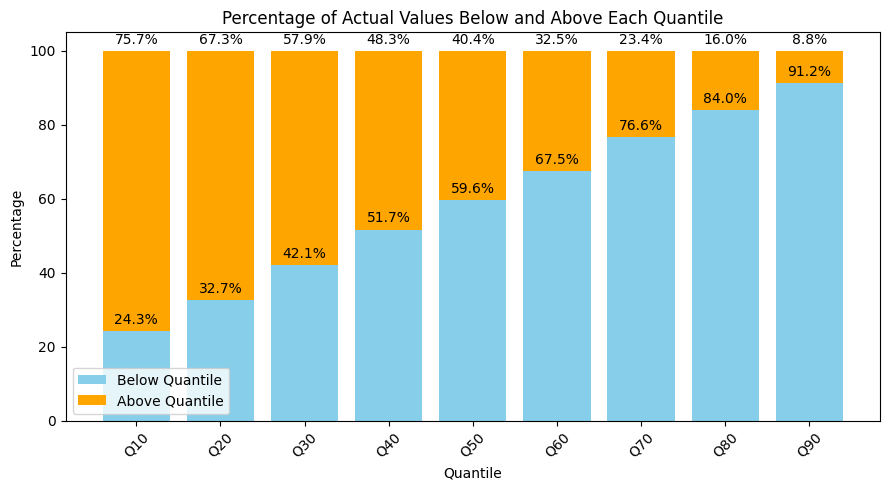

In [5]:
quantile_stats(quantile_predictions_df)

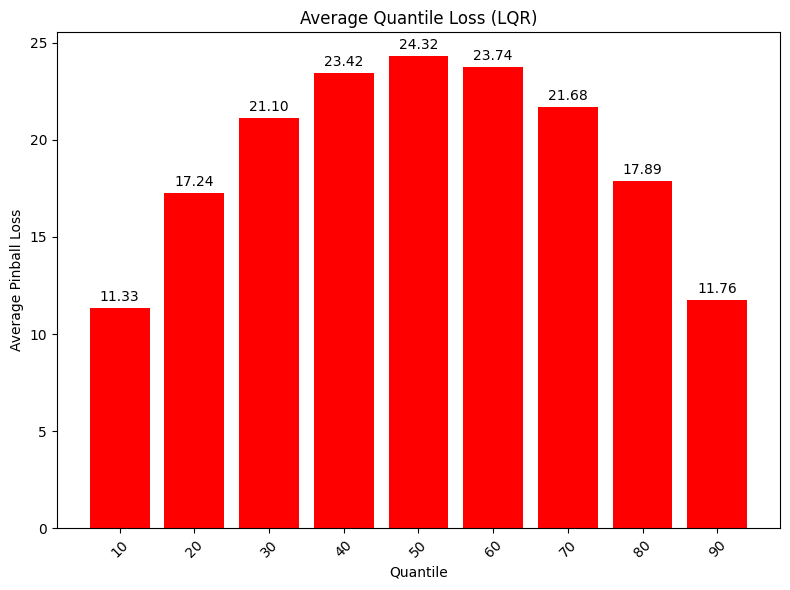

In [17]:
calculate_and_plot_average_quantile_loss(quantile_predictions_df, 'total_generation_MWh', "Average Quantile Loss (LQR)")

/tmp/ipykernel_815029/3195256083.py:20: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



NameError: name 'stats' is not defined

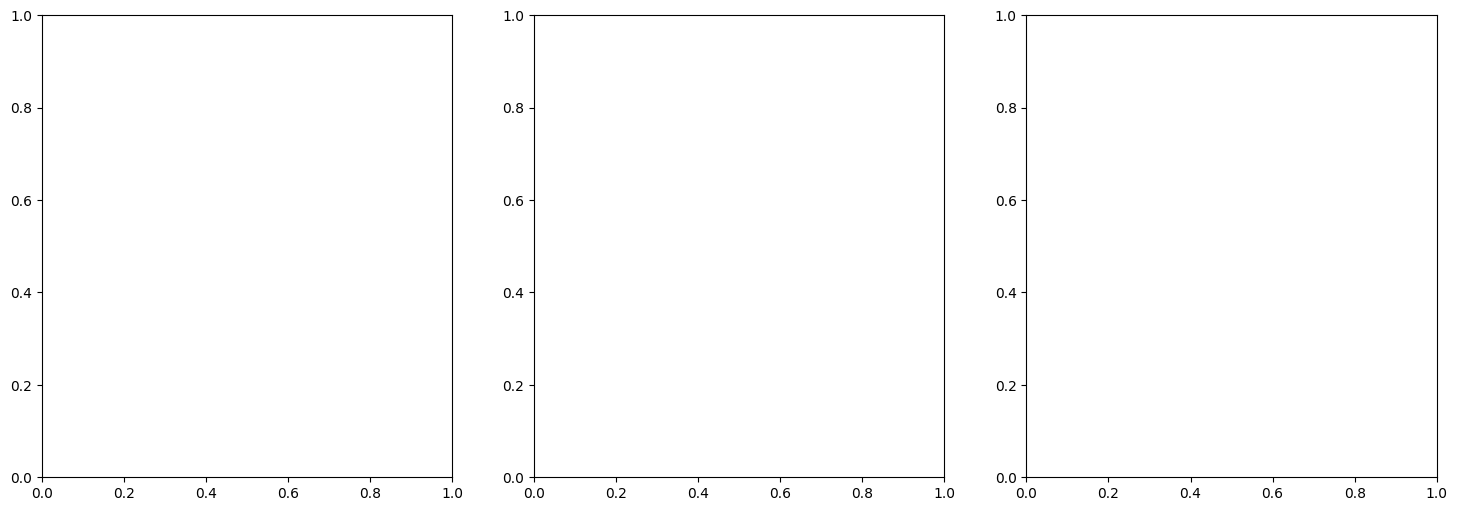

In [14]:
# Initialize dictionary to store predictions
quantile_predictions = {}
quantile_predictions['total_generation_MWh'] = test_target_variable

# Define the quantiles
quantiles = range(10, 100, 10)

# Load models and predict
for qu in quantiles:
    quantile = qu / 100.0  # Convert integer to fraction (e.g., 10 to 0.1)
    model_path = f'models/LinearQ/LQR_W&S_ALL_q{int(quantile * 100)}.joblib'
    model = joblib.load(model_path)
    quantile_predictions[f'q{qu}'] = model.predict(Test_set)

# Create DataFrame from predictions
quantile_predictions_df = pd.DataFrame(quantile_predictions)

# Ensure predictions are non-negative
quantile_columns = [col for col in quantile_predictions_df.columns if col.startswith('q')]
quantile_predictions_df[quantile_columns] = quantile_predictions_df[quantile_columns].applymap(lambda x: max(x, 0))

# Create the plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# QQ Plot
stats.probplot(quantile_predictions_df['total_generation_MWh'], dist="norm", plot=axes[0])
axes[0].set_title('QQ Plot')

# CDF Plot
ecdf_actual = ECDF(quantile_predictions_df['total_generation_MWh'])
axes[1].plot(ecdf_actual.x, ecdf_actual.y, label='Actual Data CDF')
for qu in quantiles:
    ecdf_forecast = ECDF(quantile_predictions_df[f'q{qu}'])
    axes[1].plot(ecdf_forecast.x, ecdf_forecast.y, label=f'q{qu}')
axes[1].set_title('CDF Plot')
axes[1].legend()

# Density Plot
sns.kdeplot(quantile_predictions_df['total_generation_MWh'], label='Actual Data', fill=True, ax=axes[2])
for qu in quantiles:
    sns.kdeplot(quantile_predictions_df[f'q{qu}'], label=f'q{qu}', fill=True, ax=axes[2])
axes[2].set_title('Density Plot')
axes[2].legend()

plt.tight_layout()
plt.show()